In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from model import get_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [2]:
def load_model(model_path, num_classes, use_y_channel):
    model = get_model(num_classes, use_y_channel)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_image(image, use_y_channel):
    if isinstance(image, str):
        if not os.path.exists(image):
            raise FileNotFoundError(f"Image file not found: {image}")
        image = Image.open(image).convert('RGB')
    elif not isinstance(image, Image.Image):
        raise TypeError("Input must be a file path or a PIL Image object")

    if use_y_channel:
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    return transform(image).unsqueeze(0)

In [3]:
def infer(model, image_tensor, top_k=5):
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, top_class = torch.topk(probabilities, top_k, dim=1)
    return top_prob.squeeze().tolist(), top_class.squeeze().tolist()

In [4]:
def display_predictions(images, labels, rgb_preds, y_preds, classes, num_images=4):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    
    for i in range(num_images):
        # Display the image
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Test Image {i+1}\nTrue: {classes[labels[i]]}')

        # Display RGB predictions
        axes[i, 1].axis('off')
        axes[i, 1].set_title('RGB Model Predictions')
        for j, (prob, cls) in enumerate(zip(rgb_preds[i][0], rgb_preds[i][1])):
            axes[i, 1].text(0, 1-j*0.2, f"{classes[cls]}: {prob:.2%}", fontsize=10)

        # Display Y-channel predictions
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Y-channel Model Predictions')
        for j, (prob, cls) in enumerate(zip(y_preds[i][0], y_preds[i][1])):
            axes[i, 2].text(0, 1-j*0.2, f"{classes[cls]}: {prob:.2%}", fontsize=10)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Add text annotations to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white' if cm[i, j] > cm.max() / 2 else 'black')
    
    plt.tight_layout()
    plt.show()

In [22]:
# Main execution
num_classes = 10
rgb_model_path = 'cifar10_rgb_model.pth'
y_model_path = 'cifar10_y_model.pth'

# Use images from the CIFAR-10 test set
test_image_path = 'data/cifar-10-batches-py/test_batch'

# Check if model files exist
if not os.path.exists(rgb_model_path):
    raise FileNotFoundError(f"RGB model file not found: {rgb_model_path}")
if not os.path.exists(y_model_path):
    raise FileNotFoundError(f"Y-channel model file not found: {y_model_path}")

# Load CIFAR-10 test data
with open(test_image_path, 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')

rgb_model = load_model(rgb_model_path, num_classes, use_y_channel=False)
y_model = load_model(y_model_path, num_classes, use_y_channel=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

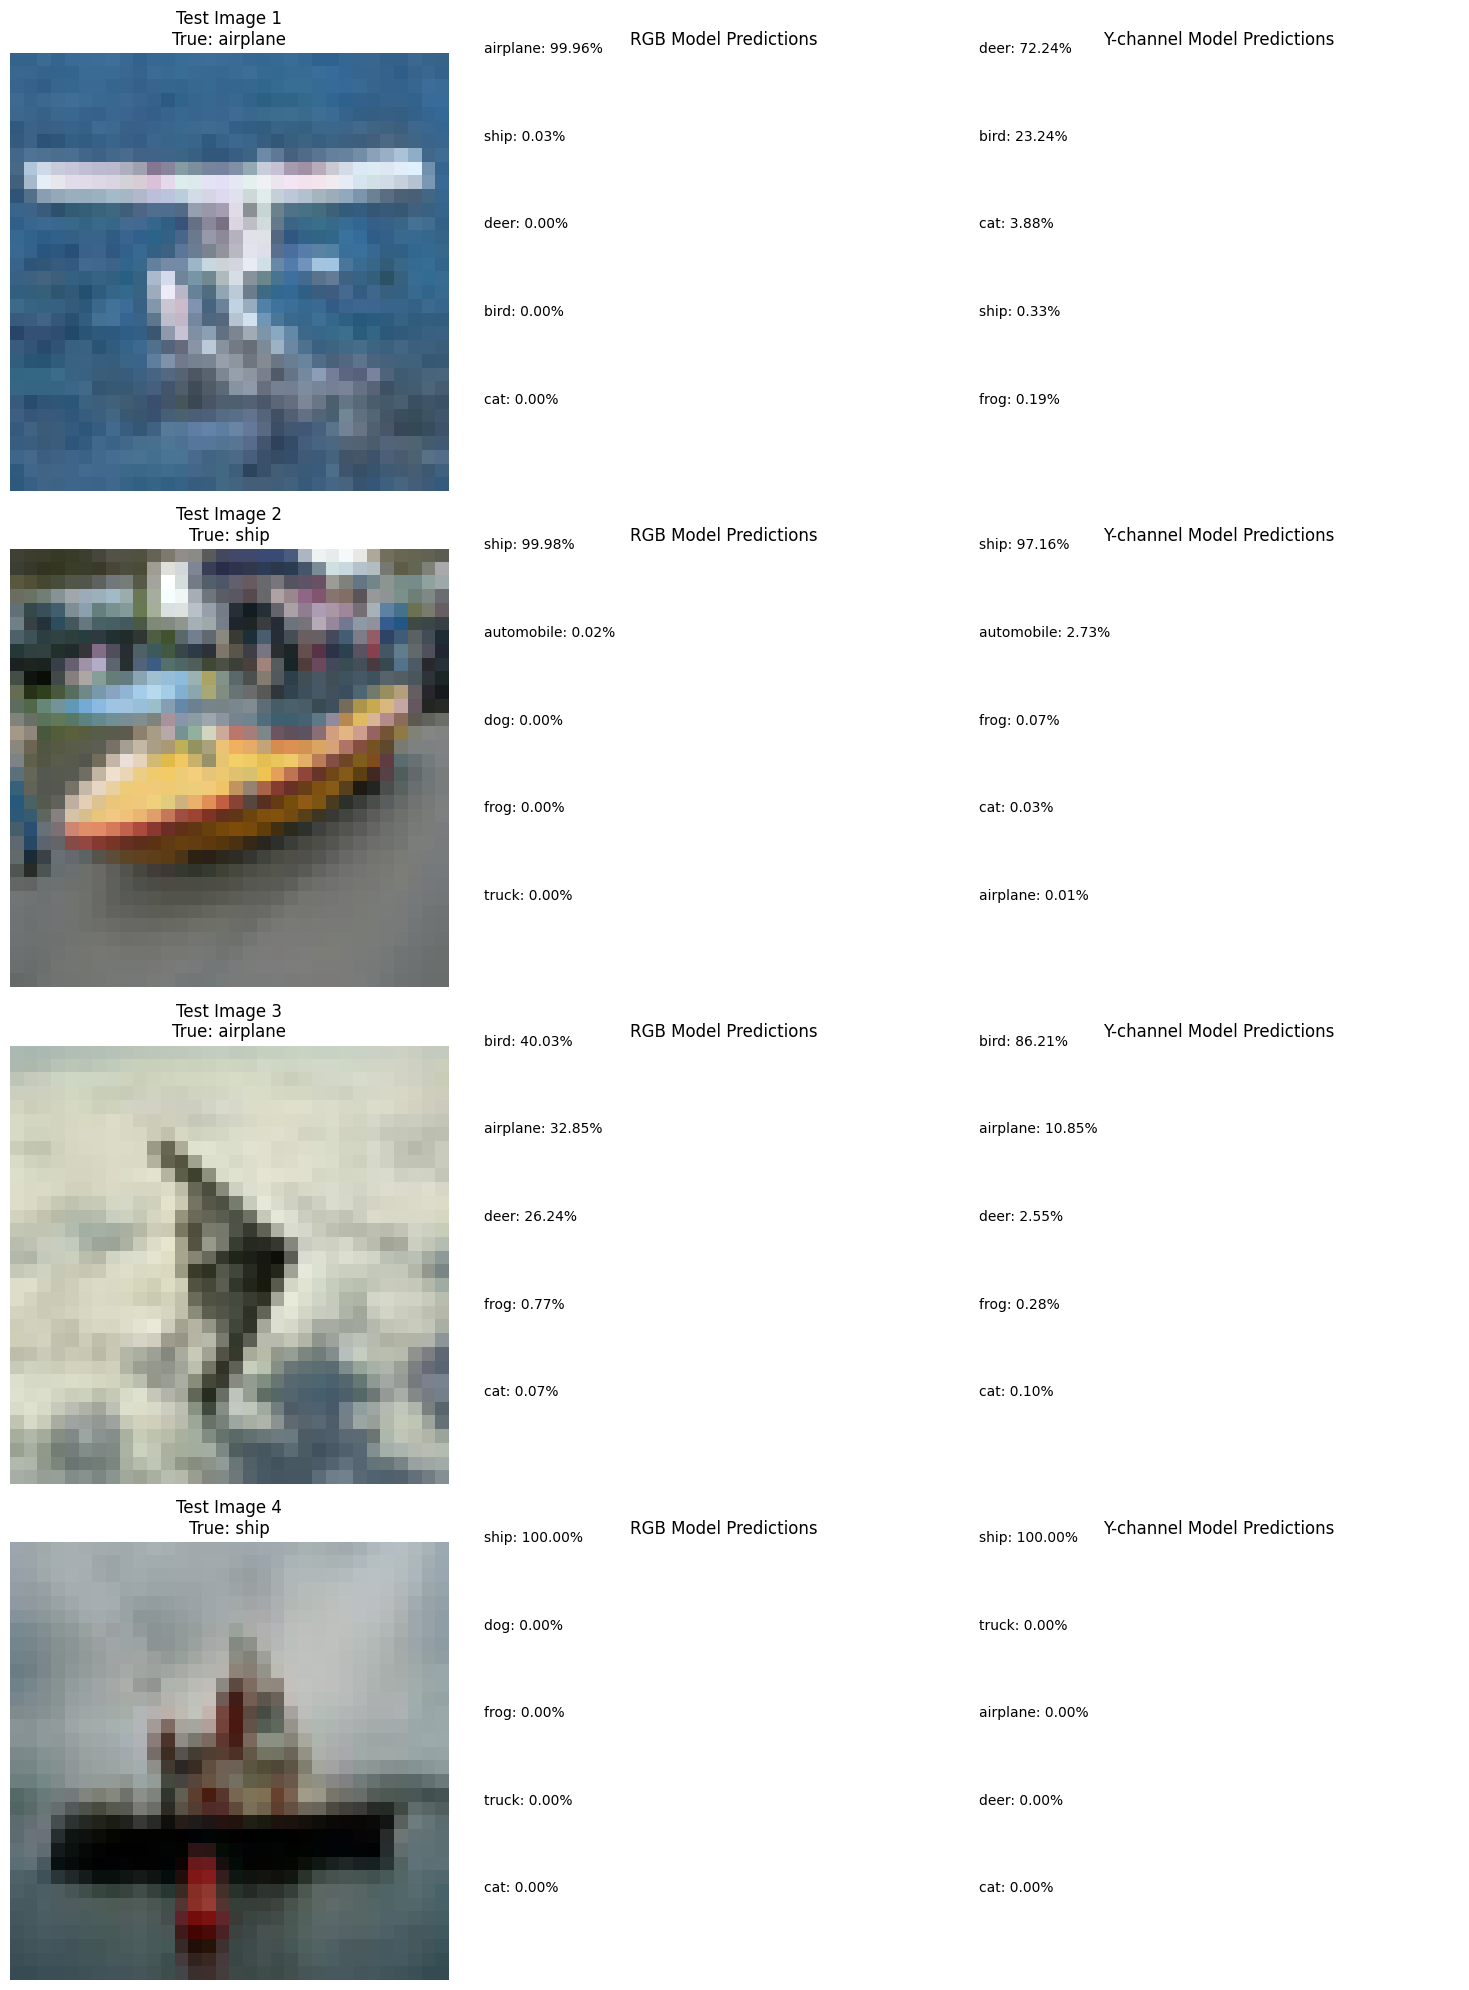

In [21]:
import random

# Display predictions
num_test_images = 4
test_images = []
test_labels = []
rgb_predictions = []
y_predictions = []

# Generate a list of random indices
random_indices = random.sample(range(len(test_data[b'data'])), num_test_images)

for idx in random_indices:
    test_image = test_data[b'data'][idx].reshape(3, 32, 32).transpose(1, 2, 0)
    test_images.append(test_image)
    test_labels.append(test_data[b'labels'][idx])
    test_image_pil = Image.fromarray(test_image)

    rgb_image = preprocess_image(test_image_pil, use_y_channel=False)
    y_image = preprocess_image(test_image_pil, use_y_channel=True)

    rgb_predictions.append(infer(rgb_model, rgb_image))
    y_predictions.append(infer(y_model, y_image))

display_predictions(test_images, test_labels, rgb_predictions, y_predictions, classes, num_test_images)

Generating confusion matrices...


Processing test data: 100%|██████████| 10000/10000 [02:04<00:00, 80.61it/s]


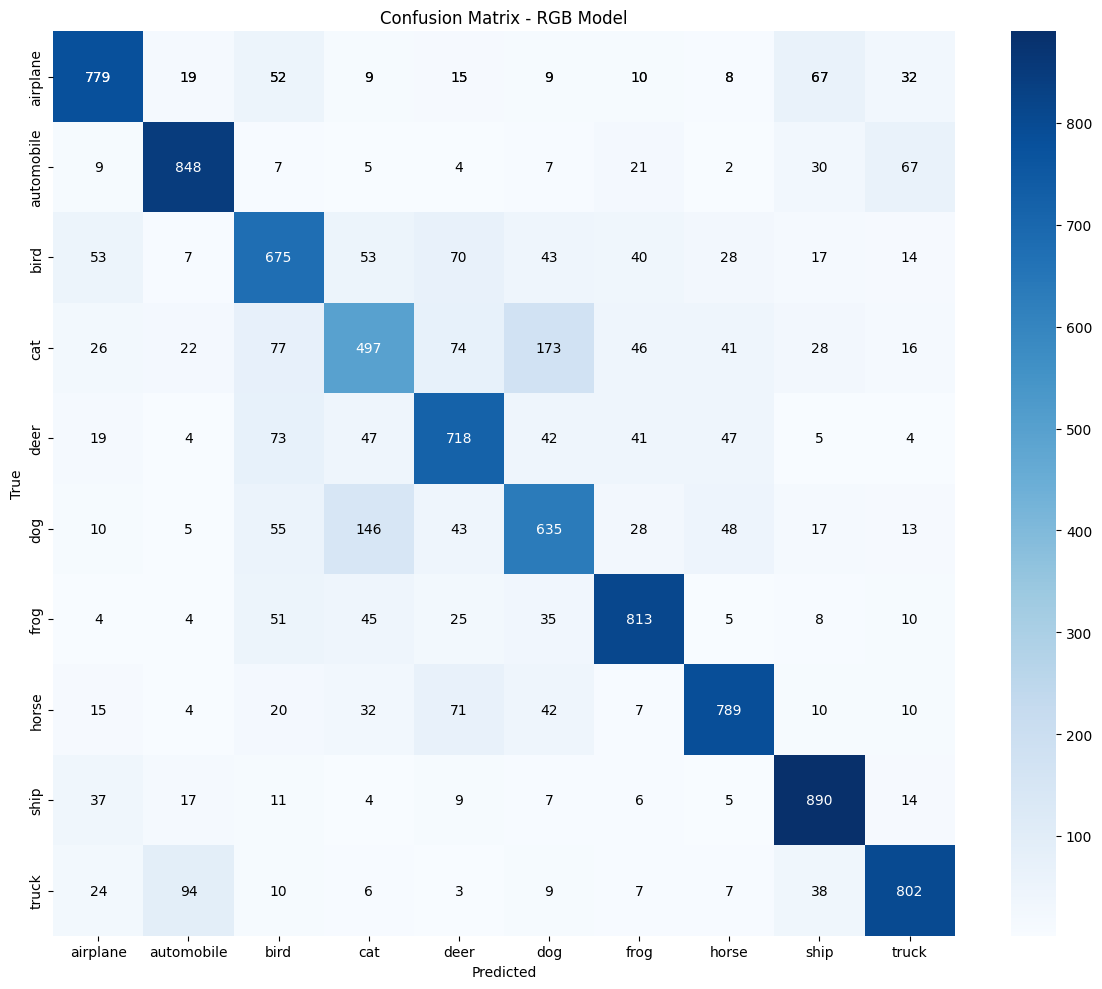

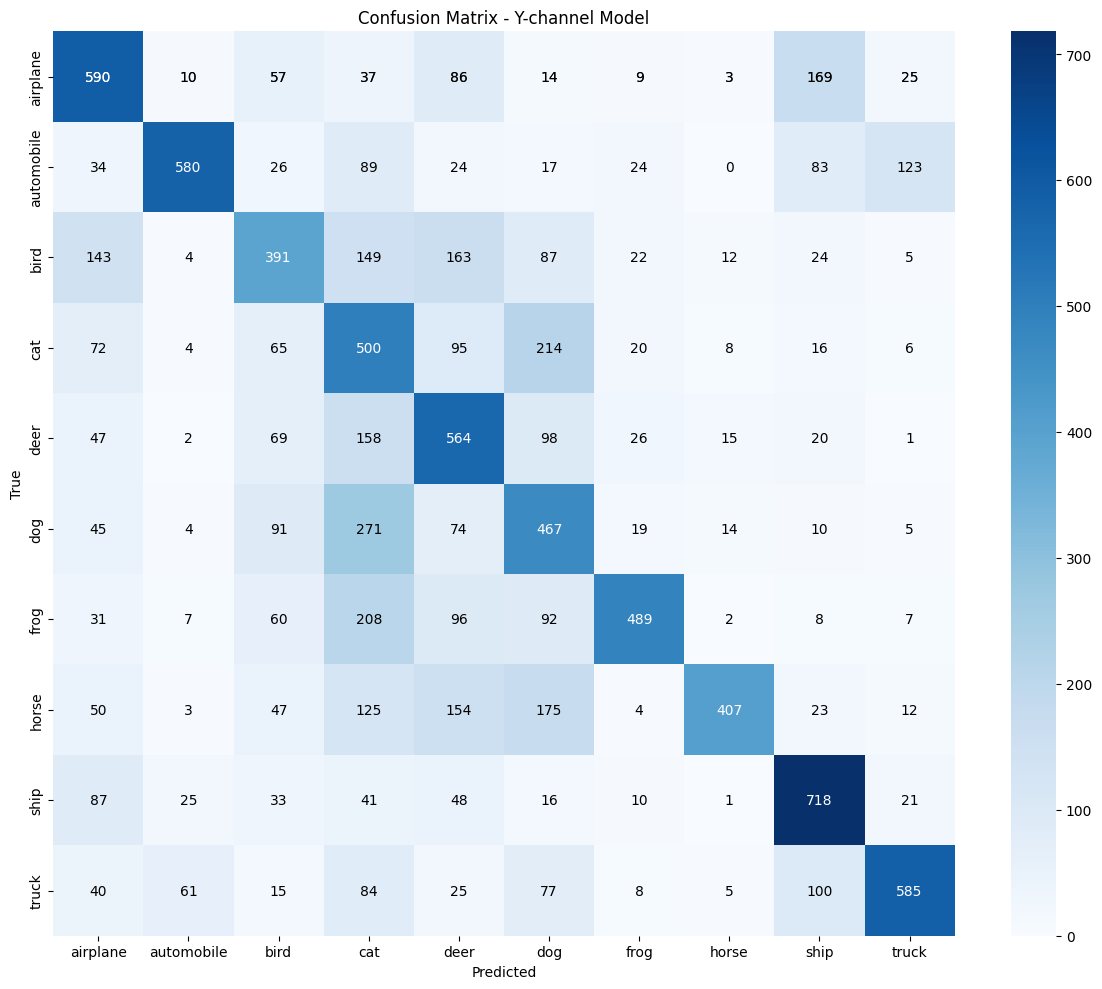

In [13]:
# Generate confusion matrices
print("Generating confusion matrices...")
rgb_true = test_data[b'labels']
rgb_pred = []
y_pred = []

for img in tqdm(test_data[b'data'], desc="Processing test data"):
    img_pil = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0))
    rgb_image = preprocess_image(img_pil, use_y_channel=False)
    y_image = preprocess_image(img_pil, use_y_channel=True)
    
    rgb_pred.append(infer(rgb_model, rgb_image)[1][0])
    y_pred.append(infer(y_model, y_image)[1][0])

# Plot confusion matrix for RGB model
plot_confusion_matrix(rgb_true, rgb_pred, classes, "Confusion Matrix - RGB Model")

# Plot confusion matrix for Y-channel model
plot_confusion_matrix(rgb_true, y_pred, classes, "Confusion Matrix - Y-channel Model")